# SIIM: Step-by-Step Image Detection for Beginners 
## Mini Part. Preprocessing for Multi-Output Regression that Detect Opacities

👉 Part 1. [EDA to Preprocessing](https://www.kaggle.com/songseungwon/siim-covid-19-detection-10-step-tutorial-1)

👉 Part 2. [Basic Modeling - Simplest Image Classification Models using Keras](https://www.kaggle.com/songseungwon/siim-covid-19-detection-10-step-tutorial-2)

> Index
```
Step 1. Import Dataset
Step 2. Test Sample data(1 row) before make the preprocessing function
     2-a. The image with the most opacity detected is taken as a sample
     2-b. visualize resized image without boxes
     2-c. extract position information
     2-d. Extract all box's information for sample image.
     2-e. Extract corrected positions that resizing ratio is calculated
     2-f. visualize resized image with boxes
Step 3. Build Function for reuse
     3-a. Test the functions that go into the function
     3-b. Build Function and Create New DataFrame with loop
     3-c. concat dataframe and save
```

Now we are going to create a neural network (drawing boxes) that detects opacity. The model is planned to be constructed in the form of simply returning four continuous dependent variables y.

To do this, we need a training dataset consisting of X matrices in the form of images and 4-y vectors.

Let's create a short training dataset in this mini part.

## Step 1. Import Dataset

In [1]:
import pandas as pd

In [2]:
train_df = pd.read_csv('/kaggle/input/siim-covid19-preprocessed-datasettrain/custom_train.csv')

In [3]:
train_df.head()

,id,boxes,label,StudyInstanceUID,OpacityCount,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,Opacity,origin_img_height,origin_img_width,height_ratio,width_ratio,path
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,2,0,1,0,0,1,3488,4256,0.073108,0.059915,/kaggle/input/siim-covid19-resized-to-256px-jp...
1,000c3a3f293f,NaN,none 1 0 0 1 1,ff0879eb20ed,0,1,0,0,0,0,2320,2832,0.109914,0.090042,/kaggle/input/siim-covid19-resized-to-256px-jp...
2,0012ff7358bc,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,2,0,1,0,0,1,2544,3056,0.100236,0.083442,/kaggle/input/siim-covid19-resized-to-256px-jp...
3,001398f4ff4f,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,1,0,0,0,1,1,3520,4280,0.072443,0.059579,/kaggle/input/siim-covid19-resized-to-256px-jp...
4,001bd15d1891,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,2,0,1,0,0,1,2800,3408,0.091071,0.074824,/kaggle/input/siim-covid19-resized-to-256px-jp...


## Step 2. Test Sample data(1 row) before make the preprocessing function

### 2-a. The image with the most opacity detected is taken as a sample.

In [4]:
sorted(train_df.OpacityCount.unique())

[0, 1, 2, 3, 4, 5, 8]

In [5]:
train_df[train_df.OpacityCount == 8]

,id,boxes,label,StudyInstanceUID,OpacityCount,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,Opacity,origin_img_height,origin_img_width,height_ratio,width_ratio,path
4560,b570de3efeed,"[{'x': 587.42021, 'y': 1377.02752, 'width': 43...",opacity 1 587.42021 1377.02752 1021.5339799999...,4b93ca3c31ad,8,0,1,0,0,1,2544,3056,0.100236,0.083442,/kaggle/input/siim-covid19-resized-to-256px-jp...


In [6]:
sample_outlier = train_df[train_df.OpacityCount == 8]
sample_outlier

,id,boxes,label,StudyInstanceUID,OpacityCount,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,Opacity,origin_img_height,origin_img_width,height_ratio,width_ratio,path
4560,b570de3efeed,"[{'x': 587.42021, 'y': 1377.02752, 'width': 43...",opacity 1 587.42021 1377.02752 1021.5339799999...,4b93ca3c31ad,8,0,1,0,0,1,2544,3056,0.100236,0.083442,/kaggle/input/siim-covid19-resized-to-256px-jp...


### 2-b. visualize resized image without boxes

In [7]:
import matplotlib.pyplot as plt

In [8]:
img = plt.imread(sample_outlier.path.values[0])
img

array([[0, 1, 1, ..., 8, 7, 6],
       [0, 1, 1, ..., 8, 7, 6],
       [0, 1, 2, ..., 8, 7, 6],
       ...,
       [0, 0, 1, ..., 7, 7, 6],
       [0, 0, 1, ..., 4, 3, 3],
       [0, 0, 1, ..., 1, 0, 0]], dtype=uint8)

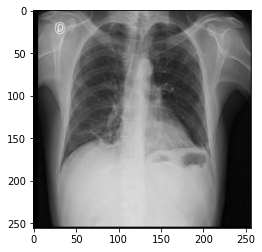

In [9]:
plt.imshow(img, cmap='gray');

### 2-c. extract position information

In [10]:
sample_box_position = sample_outlier.boxes.values[0]
sample_box_position

"[{'x': 587.42021, 'y': 1377.02752, 'width': 434.11377, 'height': 196.05139}, {'x': 503.39817, 'y': 1092.28628, 'width': 191.38351, 'height': 70.01831}, {'x': 540.74129, 'y': 802.87709, 'width': 149.3725, 'height': 121.36511}, {'x': 620.09541, 'y': 471.45691, 'width': 200.7193, 'height': 144.70456}, {'x': 2048.46975, 'y': 494.79633, 'width': 98.02563, 'height': 140.03668}, {'x': 2235.18535, 'y': 1040.93945, 'width': 172.71191, 'height': 116.69727}, {'x': 2263.19269, 'y': 1395.69908, 'width': 158.70825, 'height': 266.0697}, {'x': 2193.17433, 'y': 452.7853, 'width': 130.70093, 'height': 93.35782}]"

In [11]:
print('count of x : ',sample_box_position.count('x'))
print('count of y : ',sample_box_position.count('y'))
print('count of height : ',sample_box_position.count('height'))
print('count of width : ',sample_box_position.count('width'))

count of x :  8
count of y :  8
count of height :  8
count of width :  8


In [12]:
import re
p = re.compile("[-+]?\d*\.\d+|\d+") # extract floats from a string
p_list = p.findall(sample_box_position) # return in word bundle form
print(p_list)

# ^ : start char string
# [0-9] : range (all of numbers)
# + : no limit of count of each number
# $ : end char string

['587.42021', '1377.02752', '434.11377', '196.05139', '503.39817', '1092.28628', '191.38351', '70.01831', '540.74129', '802.87709', '149.3725', '121.36511', '620.09541', '471.45691', '200.7193', '144.70456', '2048.46975', '494.79633', '98.02563', '140.03668', '2235.18535', '1040.93945', '172.71191', '116.69727', '2263.19269', '1395.69908', '158.70825', '266.0697', '2193.17433', '452.7853', '130.70093', '93.35782']


In [13]:
count_box = len(p_list) // 4
count_box

8

### 2-d. Extract all box's information for sample image.

In [14]:
x_idx = []
y_idx = []
height_idx = []
width_idx = []
for i in range(count_box):
    i *= 4
    x_idx.append(i)
    y_idx.append(i+1)
    height_idx.append(i+2)
    width_idx.append(i+3)
print('x_idx : ',x_idx)
print('y_idx : ',y_idx)
print('height_idx : ',height_idx)
print('width_idx : ',width_idx)

x_idx :  [0, 4, 8, 12, 16, 20, 24, 28]
y_idx :  [1, 5, 9, 13, 17, 21, 25, 29]
height_idx :  [2, 6, 10, 14, 18, 22, 26, 30]
width_idx :  [3, 7, 11, 15, 19, 23, 27, 31]


In [15]:
[p_list[x] for x in x_idx]

['587.42021',
 '503.39817',
 '540.74129',
 '620.09541',
 '2048.46975',
 '2235.18535',
 '2263.19269',
 '2193.17433']

In [16]:
x_list = [float(p_list[idx]) for idx in x_idx]
y_list = [float(p_list[idx]) for idx in y_idx]
height_list = [float(p_list[idx]) for idx in height_idx]
width_list = [float(p_list[idx]) for idx in width_idx]
print('x_list : ',x_list)
print('y_list : ',y_list)
print('height_list : ',height_list)
print('width_list : ',width_list)

x_list :  [587.42021, 503.39817, 540.74129, 620.09541, 2048.46975, 2235.18535, 2263.19269, 2193.17433]
y_list :  [1377.02752, 1092.28628, 802.87709, 471.45691, 494.79633, 1040.93945, 1395.69908, 452.7853]
height_list :  [434.11377, 191.38351, 149.3725, 200.7193, 98.02563, 172.71191, 158.70825, 130.70093]
width_list :  [196.05139, 70.01831, 121.36511, 144.70456, 140.03668, 116.69727, 266.0697, 93.35782]


### 2-e. Extract corrected positions that resizing ratio is calculated

In [17]:
train_df[train_df.OpacityCount == 8]

,id,boxes,label,StudyInstanceUID,OpacityCount,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,Opacity,origin_img_height,origin_img_width,height_ratio,width_ratio,path
4560,b570de3efeed,"[{'x': 587.42021, 'y': 1377.02752, 'width': 43...",opacity 1 587.42021 1377.02752 1021.5339799999...,4b93ca3c31ad,8,0,1,0,0,1,2544,3056,0.100236,0.083442,/kaggle/input/siim-covid19-resized-to-256px-jp...


In [18]:
sample_height_ratio = train_df[train_df.OpacityCount == 8].height_ratio.values
sample_width_ratio = train_df[train_df.OpacityCount == 8].width_ratio.values

In [19]:
x_list

[587.42021,
 503.39817,
 540.74129,
 620.09541,
 2048.46975,
 2235.18535,
 2263.19269,
 2193.17433]

In [20]:
sample_height_ratio

array([0.10023585])

In [21]:
resized_x_list = x_list*sample_width_ratio
resized_y_list = y_list*sample_height_ratio
resized_width_list = width_list*sample_width_ratio
resized_height_list = height_list*sample_height_ratio

In [22]:
print('resized_x_list : \n',resized_x_list)
print('resized_y_list : \n',resized_y_list)
print('resized_width_list : \n',resized_width_list)
print('resized_height_list : \n',resized_height_list)

resized_x_list : 
 [ 49.01575705  42.00475568  45.12075555  51.74225443 170.92924943
 186.50924877 188.84624867 183.00374809]
resized_y_list : 
 [138.02752264 109.48624269  80.4770668   47.25688367  49.59633025
 104.33944959 139.89908231  45.38531899]
resized_width_list : 
 [16.35900015  5.84249642 10.12699707 12.07449699 11.68499784  9.73750126
 22.20149656  7.79000134]
resized_height_list : 
 [43.51376232 19.18348862 14.97247936 20.11926946  9.82568225 17.31192494
 15.90825619 13.10091869]


### 2-f. visualize resized image with boxes

In [23]:
import matplotlib
import matplotlib.pyplot as plt

In [24]:
resized_x_list

array([ 49.01575705,  42.00475568,  45.12075555,  51.74225443,
       170.92924943, 186.50924877, 188.84624867, 183.00374809])

In [25]:
count_box

8

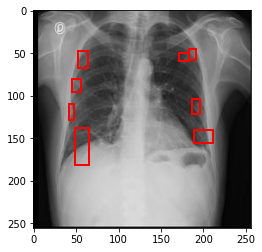

In [26]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
for i in range(count_box):
    p = matplotlib.patches.Rectangle((resized_x_list[i], resized_y_list[i]),
                                      resized_width_list[i], resized_height_list[i],
                                      ec='r', fc='none', lw=2.)
    ax.add_patch(p)
    
ax.imshow(img, cmap='gray')
plt.show()

## Step 3. Build Function for reuse

In [27]:
train_df.head()

,id,boxes,label,StudyInstanceUID,OpacityCount,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,Opacity,origin_img_height,origin_img_width,height_ratio,width_ratio,path
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,2,0,1,0,0,1,3488,4256,0.073108,0.059915,/kaggle/input/siim-covid19-resized-to-256px-jp...
1,000c3a3f293f,NaN,none 1 0 0 1 1,ff0879eb20ed,0,1,0,0,0,0,2320,2832,0.109914,0.090042,/kaggle/input/siim-covid19-resized-to-256px-jp...
2,0012ff7358bc,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,2,0,1,0,0,1,2544,3056,0.100236,0.083442,/kaggle/input/siim-covid19-resized-to-256px-jp...
3,001398f4ff4f,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,1,0,0,0,1,1,3520,4280,0.072443,0.059579,/kaggle/input/siim-covid19-resized-to-256px-jp...
4,001bd15d1891,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,2,0,1,0,0,1,2800,3408,0.091071,0.074824,/kaggle/input/siim-covid19-resized-to-256px-jp...


### 3-a. Test the functions that go into the function

In [28]:
p = re.compile("[-+]?\d*\.\d+|\d+")
box_positions = train_df.boxes.apply(lambda x : p.findall(str(x)))
box_positions

0       [789.28836, 582.43035, 1026.65662, 1917.30292,...
1                                                      []
2       [677.42216, 197.97662, 867.79767, 999.78214, 1...
3                      [2729, 2181.33331, 948.00012, 604]
4       [623.23328, 1050, 714, 1106, 2578.56661, 998.6...
                              ...                        
6329                                                   []
6330                                                   []
6331    [2197.38566, 841.07361, 316.41699, 451.63758, ...
6332    [2729.27083, 332.26044, 1496.25016, 2604.58334...
6333    [208.86463, 91.53448, 450.96747, 628.05473, 75...
Name: boxes, Length: 6334, dtype: object

In [29]:
train_df.OpacityCount

0       2
1       0
2       2
3       1
4       2
       ..
6329    0
6330    0
6331    3
6332    2
6333    2
Name: OpacityCount, Length: 6334, dtype: int64

### 3-b. Build Function and Create New DataFrame with loop

In [30]:
import numpy as np

def resize_box_position(df, c):
    count_box = train_df.OpacityCount[c]
    x_idx = []
    y_idx = []
    height_idx = []
    width_idx = []

    for i in range(count_box):
        i *= 4
        x_idx.append(i)
        y_idx.append(i+1)
        height_idx.append(i+2)
        width_idx.append(i+3)

    if train_df.boxes[c] != train_df.boxes[c]:
        return pd.Series([0,0,0,0], index=df.columns)
    
    else:
        p_list = p.findall(train_df.boxes[c]) 
        x_list = [float(p_list[idx]) for idx in x_idx]
        y_list = [float(p_list[idx]) for idx in y_idx]
        height_list = [float(p_list[idx]) for idx in height_idx]
        width_list = [float(p_list[idx]) for idx in width_idx]

        x_ratio = np.array(train_df.width_ratio[c])
        y_ratio = np.array(train_df.height_ratio[c])

        resized_x_list = x_list*x_ratio
        resized_y_list = y_list*y_ratio
        resized_width_list = width_list*x_ratio
        resized_height_list = height_list*y_ratio
        return pd.Series([resized_x_list, resized_y_list, resized_width_list, resized_height_list], index=df.columns)

In [31]:
resized_box_x = []
resized_box_y = []
resized_box_width = []
resized_box_height = []

df = pd.DataFrame(columns=['resized_box_x', 'resized_box_y', 'resized_box_width', 'resized_box_height'])

for idx in train_df.index:
    df = df.append(resize_box_position(df, idx), ignore_index=True)
    if idx % 500 == 0:
        print('saved - {}/{}'.format(idx, max(train_df.index)))
    elif idx == 6333:
        print('complete - {}/{}'.format(idx, max(train_df.index)))

saved - 0/6333
saved - 500/6333
saved - 1000/6333
saved - 1500/6333
saved - 2000/6333
saved - 2500/6333
saved - 3000/6333
saved - 3500/6333
saved - 4000/6333
saved - 4500/6333
saved - 5000/6333
saved - 5500/6333
saved - 6000/6333
complete - 6333/6333


In [32]:
df

,resized_box_x,resized_box_y,resized_box_width,resized_box_height
0,"[47.29053848684204, 134.5647510338344]","[42.580200473050446, 43.22171628440366]","[114.8759973214284, 105.54396315789458]","[75.05660495986237, 80.02830077408255]"
1,0,0,0,0
2,"[56.52573651832457, 149.5864244764397]","[19.844354599056587, 40.35019162735846]","[83.4242296138743, 100.49453206806277]","[86.9844362617924, 61.848259316037684]"
3,[162.59228971962602],[158.0227255823863],[35.98598130841118],[68.67614505681816]
4,"[46.6327718309859, 192.9385227552816]","[95.62499999999993, 90.95000030357136]","[82.7552816901408, 83.80281690140842]","[65.02499999999995, 60.35000030357138]"
...,...,...,...,...
6329,0,0,0,0
6330,0,0,0,0
6331,"[183.7158502622949, 198.63891093442606, 59.130...","[89.81313674623111, 195.50962657035166, 77.106...","[37.759863245901606, 25.550090360655716, 70.99...","[33.788246419597975, 28.590038316582902, 41.87..."
6332,"[163.5253904252817, 60.26367187499991]","[24.290829185779813, 115.85225431479356]","[156.05468789943586, 46.48437719689842]","[109.38755470183484, 48.414113575114676]"


### 3-c. Concat DataFrame and Save

In [33]:
train_df = pd.concat([train_df,df], axis=1)
train_df

,id,boxes,label,StudyInstanceUID,OpacityCount,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,Opacity,origin_img_height,origin_img_width,height_ratio,width_ratio,path,resized_box_x,resized_box_y,resized_box_width,resized_box_height
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,2,0,1,0,0,1,3488,4256,0.073108,0.059915,/kaggle/input/siim-covid19-resized-to-256px-jp...,"[47.29053848684204, 134.5647510338344]","[42.580200473050446, 43.22171628440366]","[114.8759973214284, 105.54396315789458]","[75.05660495986237, 80.02830077408255]"
1,000c3a3f293f,NaN,none 1 0 0 1 1,ff0879eb20ed,0,1,0,0,0,0,2320,2832,0.109914,0.090042,/kaggle/input/siim-covid19-resized-to-256px-jp...,0,0,0,0
2,0012ff7358bc,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,2,0,1,0,0,1,2544,3056,0.100236,0.083442,/kaggle/input/siim-covid19-resized-to-256px-jp...,"[56.52573651832457, 149.5864244764397]","[19.844354599056587, 40.35019162735846]","[83.4242296138743, 100.49453206806277]","[86.9844362617924, 61.848259316037684]"
3,001398f4ff4f,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,1,0,0,0,1,1,3520,4280,0.072443,0.059579,/kaggle/input/siim-covid19-resized-to-256px-jp...,[162.59228971962602],[158.0227255823863],[35.98598130841118],[68.67614505681816]
4,001bd15d1891,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,2,0,1,0,0,1,2800,3408,0.091071,0.074824,/kaggle/input/siim-covid19-resized-to-256px-jp...,"[46.6327718309859, 192.9385227552816]","[95.62499999999993, 90.95000030357136]","[82.7552816901408, 83.80281690140842]","[65.02499999999995, 60.35000030357138]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6329,ffcc6edd9445,NaN,none 1 0 0 1 1,7e6c68462e06,0,1,0,0,0,0,4240,3480,0.060142,0.073276,/kaggle/input/siim-covid19-resized-to-256px-jp...,0,0,0,0
6330,ffd91a2c4ca0,NaN,none 1 0 0 1 1,8332bdaddb6e,0,1,0,0,0,0,2800,3408,0.091071,0.074824,/kaggle/input/siim-covid19-resized-to-256px-jp...,0,0,0,0
6331,ffd9b6cf2961,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",opacity 1 2197.38566 841.07361 2513.80265 1292...,7eed9af03814,3,0,1,0,0,1,2388,3050,0.106784,0.083607,/kaggle/input/siim-covid19-resized-to-256px-jp...,"[183.7158502622949, 198.63891093442606, 59.130...","[89.81313674623111, 195.50962657035166, 77.106...","[37.759863245901606, 25.550090360655716, 70.99...","[33.788246419597975, 28.590038316582902, 41.87..."
6332,ffdc682f7680,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d,2,0,1,0,0,1,3488,4256,0.073108,0.059915,/kaggle/input/siim-covid19-resized-to-256px-jp...,"[163.5253904252817, 60.26367187499991]","[24.290829185779813, 115.85225431479356]","[156.05468789943586, 46.48437719689842]","[109.38755470183484, 48.414113575114676]"


In [34]:
train_df.to_csv('train_full_info.csv')